In [1]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import fast_dsift, double_igo

from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, plot_graph

from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    ProjectOutForwardGaussNewton, 
    ProjectOutInverseGaussNewton,
    ProjectOutAsymmetricGaussNewton,
    ProjectOutBidirectionalGaussNewtonCombined,
    ProjectOutBidirectionalGaussNewtonSimultaneous,
    ProjectOutBidirectionalGaussNewtonAlternated)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=None):
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - done.                           


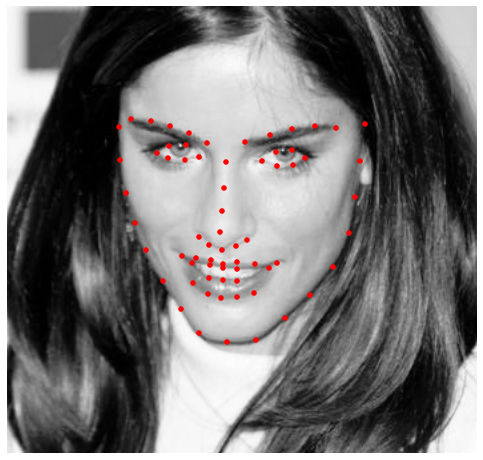

In [3]:
visualize_images(training_images)

## Load test data

In [5]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


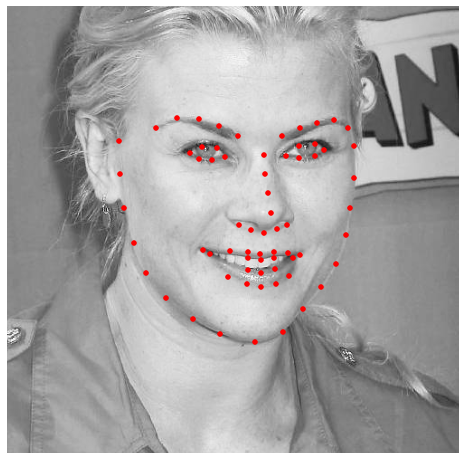

In [6]:
visualize_images(test_images)

## Build Active Appearance Models

In [8]:
features = fast_dsift
diagonal = 200
max_shape_components= 25
max_appearance_components = None

#### AAM

In [9]:
aam = HolisticAAM(
    training_images, 
    group='ibug_face_66', 
    verbose=True,
    features=features,
    diagonal=diagonal, 
    max_shape_components=max_shape_components,
    max_appearance_components=max_appearance_components)

Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done


## Fit Active Appearance Models

In [42]:
sampling_step = [16, 16]
n_shape = [3, 12]
n_appearance = [809, 809]
l = 0.5

#### AAM Fitter

In [ ]:
fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutForwardGaussNewton, l=l),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_2 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutInverseGaussNewton, l=l),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_3 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutAsymmetricGaussNewton, l=l), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_4 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutBidirectionalGaussNewtonCombined, l=l), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_5 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutBidirectionalGaussNewtonSimultaneous, l=l),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_6 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutBidirectionalGaussNewtonAlternated, l=l),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

#### Fitting loop

In [ ]:
fitters = [fitter_1,
           fitter_2,
           fitter_3,
           fitter_4,
           fitter_5,
           fitter_6]

n_fitters = len(fitters)

fitters_results = []

for j, i in enumerate(test_images[:100]):
    
    np.random.seed(j)
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitters[0].noisy_shape_from_shape(gt_s, noise_percentage=0.02)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

Image: 6 - Initial error: 0.0718427851336 - Final error: 0.0177253909161        

## Visualize Results

In [ ]:
visualize_fitting_result(fitters_results)

In [ ]:
initial_errors = [fr.initial_error() for fr in fitters_results[::n_fitters]]

final_errors_1 = [fr.final_error() for fr in fitters_results[::n_fitters]]
final_errors_2 = [fr.final_error() for fr in fitters_results[1::n_fitters]]
final_errors_3 = [fr.final_error() for fr in fitters_results[2::n_fitters]]
final_errors_4 = [fr.final_error() for fr in fitters_results[3::n_fitters]]
final_errors_5 = [fr.final_error() for fr in fitters_results[4::n_fitters]]
final_errors_6 = [fr.final_error() for fr in fitters_results[5::n_fitters]]

errors = [initial_errors, 
          final_errors_1, 
          final_errors_2, 
          final_errors_3, 
          final_errors_4,
          final_errors_5,
          final_errors_6]

In [ ]:
plot_ced(errors, legend_entries=['ini', 'f', 'i', 'a', 'b_c', 'b_s', 'b_a'])

In [ ]:
print 'ini:', np.mean(initial_errors), 'std_1:', np.std(initial_errors), 'median:', np.median(initial_errors) 
print 'mean_1:', np.mean(final_errors_1), 'std_1:', np.std(final_errors_1), 'median_1:', np.median(final_errors_1) 
print 'mean_2:', np.mean(final_errors_2), 'std_2:', np.std(final_errors_2), 'median_2:', np.median(final_errors_2) 
print 'mean_3:', np.mean(final_errors_3), 'std_3:', np.std(final_errors_3), 'median_3:', np.median(final_errors_3) 
print 'mean_4:', np.mean(final_errors_4), 'std_4:', np.std(final_errors_4), 'median_4:', np.median(final_errors_4) 
print 'mean_5:', np.mean(final_errors_5), 'std_5:', np.std(final_errors_5), 'median_5:', np.median(final_errors_5)
print 'mean_6:', np.mean(final_errors_6), 'std_6:', np.std(final_errors_6), 'median_6:', np.median(final_errors_6) 

In [ ]:
errors_1 = np.mean(np.asarray([fr.errors() for fr in fitters_results[::n_fitters]]), axis=0)
errors_2 = np.mean(np.asarray([fr.errors() for fr in fitters_results[1::n_fitters]]), axis=0)
errors_3 = np.mean(np.asarray([fr.errors() for fr in fitters_results[2::n_fitters]]), axis=0)
errors_4 = np.mean(np.asarray([fr.errors() for fr in fitters_results[3::n_fitters]]), axis=0)
errors_5 = np.mean(np.asarray([fr.errors() for fr in fitters_results[4::n_fitters]]), axis=0)
errors_6 = np.mean(np.asarray([fr.errors() for fr in fitters_results[5::n_fitters]]), axis=0)

errors = [errors_1, 
          errors_2, 
          errors_3, 
          errors_4,
          errors_5,
          errors_6]

In [ ]:
plot_graph(np.arange(0, 22), 
           errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

In [ ]:
errors_1 = np.median(np.asarray([fr.errors() for fr in fitters_results[::n_fitters]]), axis=0)
errors_2 = np.median(np.asarray([fr.errors() for fr in fitters_results[1::n_fitters]]), axis=0)
errors_3 = np.median(np.asarray([fr.errors() for fr in fitters_results[2::n_fitters]]), axis=0)
errors_4 = np.median(np.asarray([fr.errors() for fr in fitters_results[3::n_fitters]]), axis=0)
errors_5 = np.median(np.asarray([fr.errors() for fr in fitters_results[4::n_fitters]]), axis=0)
errors_6 = np.median(np.asarray([fr.errors() for fr in fitters_results[5::n_fitters]]), axis=0)

errors = [errors_1, 
          errors_2, 
          errors_3, 
          errors_4,
          errors_5,
          errors_6]

In [ ]:
plot_graph(np.arange(0, 22), 
           errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

In [ ]:
%timeit fr = fitter_1.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_2.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_4.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_5.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_6.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 

In [ ]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [320]:
# %lprun -f ProjectOutBidirectionalGaussNewtonSimultaneous._solve fitter_5.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 